<a href="https://colab.research.google.com/github/sidharth178/Cat-Dog-Classification-Flask-App/blob/master/cat_dog_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Table of Contents**

1. Introduction
1. Import library
1. Fetch datasets from kaggle
1. Prepare training data
1. Data pre-processing
1. Model building
1. Prepare testing data
1. Find prediction



# **Introduction**

In this project, we'll write an algorithm to classify whether images contain either a dog or a cat.  This is easy for humans, dogs, and cats but our computer will find it a bit more difficult.
### Data Description
The folder "train" contains two sub-folders "cats" & "dogs" which contain images of cats and dogs respectively.The folder "test1" contain unknown images which we have to classify.
### Data
To download the Dataset click [here](https://www.kaggle.com/c/dogs-vs-cats/data)
### Objective
To build a deep learning classification model which classify whether images contain either a dog or a cat. 



# **1. Import Library**

In [1]:
import numpy as np
import pandas as pd 
import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV


# **2. Fetch datasets from kaggle**

In [2]:
# Step-1: create .kaggle directory
!mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
# Step-2: create a API token in your kaggle account.Upload this token("kaggle.json") on any folder here.move this file into ~/.kaggle.
# Below code is for moving ".json" file
!mv /content/sample_data/kaggle.json ~/.kaggle/kaggle.json

In [4]:
# Step-3: give authorization to KaggleApi
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
# Step-4: Download datasets from kaggle using API
!kaggle competitions download -c dogs-vs-cats

test1.zip: Skipping, found more recently modified local copy (use --force to force download)
sampleSubmission.csv: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
# unzip the dataset
from zipfile import ZipFile
zf = ZipFile('/content/train.zip')
zf.extractall('/content/sample_data') #save files in selected folder
zf.close()

# **3. Prepare Training Data**
Here we will create dataframe which will store all file names in "filenames" column and value "1" for "dog" and "0" for "cat". 

In [8]:
filenames = os.listdir("/content/sample_data/train")
categories = []
for name in filenames:
    category = name.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

image_df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [9]:
# See top 5 rows of the dataset
image_df.head()

,filename,category
0,dog.7526.jpg,1
1,cat.6376.jpg,0
2,cat.8304.jpg,0
3,cat.864.jpg,0
4,cat.9071.jpg,0


In [10]:
# See buttom 5 cell of the dataset
image_df.tail()

,filename,category
24995,cat.6073.jpg,0
24996,dog.12445.jpg,1
24997,cat.2362.jpg,0
24998,cat.6328.jpg,0
24999,cat.5876.jpg,0


In [11]:
image_df.shape

(25000, 2)

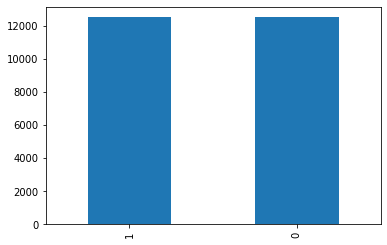

In [12]:
# visualize number of cats and dogs present in the dataframe
image_df['category'].value_counts().plot.bar()

## **3.1. Sample Image**

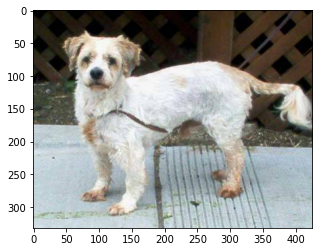

In [13]:
sample = random.choice(filenames)
image = load_img("/content/sample_data/train/"+sample)
plt.imshow(image)

# **4.Data Pre-processing**
As we use image genaretor `with class_mode="categorical"`. We need to convert column category into string. Then imagenerator will convert it one-hot encoding. 

So we will convert 1 to "dog" and 0 to "cat"

In [14]:
# replace 0 as "cat" & 1 as "dog"
image_df["category"] = image_df["category"].replace({0: 'cat', 1: 'dog'}) 

In [15]:
# split the dataset for training & testing
train_df, validate_df = train_test_split(image_df, test_size=0.20, random_state=23)
# training dataset
train_df = train_df.reset_index(drop=True)
# testing dataset
validate_df = validate_df.reset_index(drop=True)

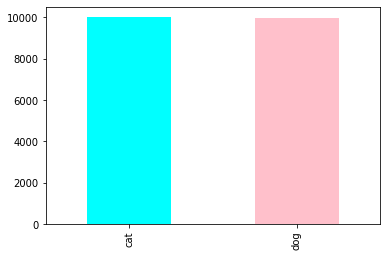

In [16]:
# see frequency of class variables in target column of training dataset
train_df['category'].value_counts().plot.bar(color=["cyan","pink"])

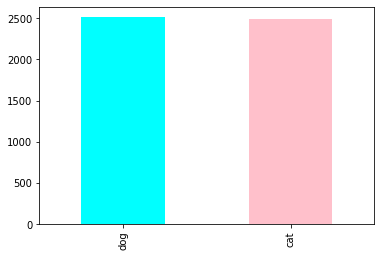

In [17]:
# see frequency of class variables in target column of testing dataset
validate_df['category'].value_counts().plot.bar(color=["cyan","pink"])

## **4.1. Define Constants**

In [18]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
batch_size=15

In [19]:
train_df_size = train_df.shape[0]
validate_df_size = validate_df.shape[0]

## **4.2. Training Generator**

In [20]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/sample_data/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


## **4.3. Validation Generator**

In [21]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/sample_data/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


## **4.4. See how generator work**

In [22]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "/content/sample_data/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


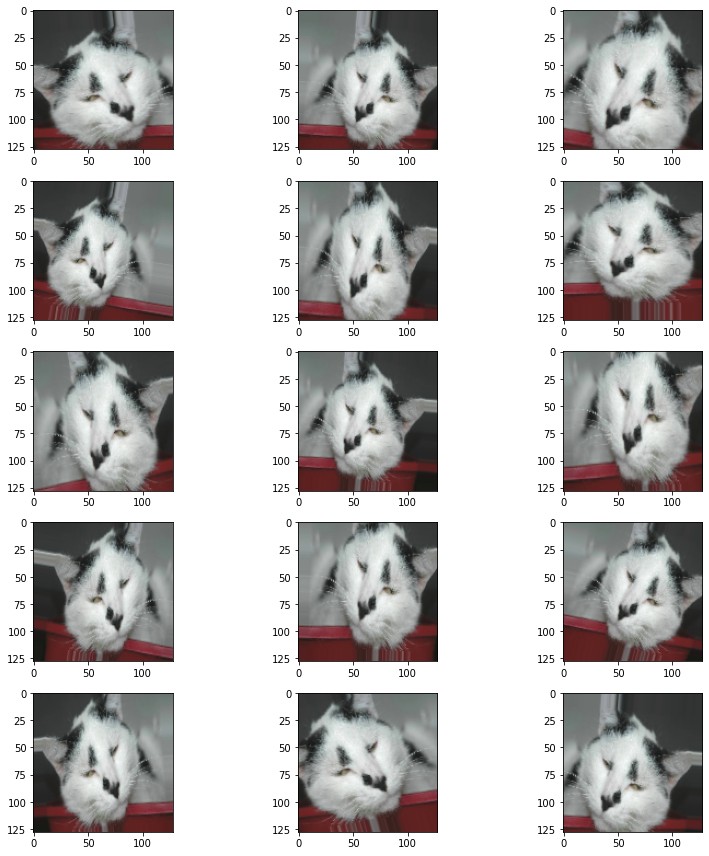

In [23]:
# visualize generated images from one image
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

# **5. Model Building**
<img src="https://media.geeksforgeeks.org/wp-content/uploads/cat-vs-dog.jpg" width="100%"/>

* **Conv Layer**: Convolutional layers are the layers where filters are applied to the original image, or to other feature maps in a deep CNN.
* **Conv2D Layer**: Conv2D is a 2D Convolution Layer, this layer creates a convolution kernel that is wind with layers input which helps produce a tensor of outputs.
* **Pooling Layer**: Its function is to progressively reduce the spatial size of the representation to reduce the amount of parameters and computation in the network.
* **Fully Connected Layer**: It connect the network from a layer to another layer
* **Output Layer**: It is the predicted values layer. 
* **BatchNormalization**: Layer that normalizes its inputs.Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.

In [24]:
# initializing the CNN
model = Sequential()

# Convolution layer-1
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Convolution layer-2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Convolution layer-3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# flattening layer
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output layer
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# summary of model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

## **5.1. Callback Functions**
A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training.
- **EarlyStopping** : Used to avoid overfitting.Here we'll stop the training if there is no improvement in 3 conjecutive epochs.
- **ModelCheckpoint** : This callback saves the model after every epoch.The model'll save in a particular location with minimun 'val_loss'.
- **ReduceLROnPlateau** : It reduces learning rate when a metric has stopped improving.
For more about callback function click [here](https://www.kdnuggets.com/2019/08/keras-callbacks-explained-three-minutes.html) [here](https://keras.io/api/callbacks/)

In [25]:
# EarlyStopping
earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 7,
                          verbose = 1,
                          restore_best_weights = True)

# ModelCheckPoint
checkPoint = keras.callbacks.ModelCheckpoint(filepath="/content/sample_data/cd_model.h5",
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             verbose=1)

# ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

# TBoard = tf.keras.callbacks.TensorBoard(log_dir='./logs')

In [26]:
callbacks = [earlystop , checkPoint, learning_rate_reduction]

In [27]:
# this code is to show how much time required to train the model using different algorithms
from datetime import datetime
def timer(start_time= None):
  if not start_time:
    start_time=datetime.now()
    return start_time
  elif start_time:
    thour,temp_sec=divmod((datetime.now()-start_time).total_seconds(),3600)
    tmin,tsec=divmod(temp_sec,60)
    print('\n Time taken: %i hours %i minutes and %s seconds. '% (thour,tmin,round(tsec,2)))

## **5.2. Model Fitting**

In [28]:
start_time=timer(None)
epochs=3 if FAST_RUN else 40   # 37 is good
classifier = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validate_df_size//batch_size,
    steps_per_epoch=train_df_size//batch_size,
    callbacks=callbacks
)
timer(start_time)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/40
1333/1333 [==============================] - 167s 123ms/step - loss: 1.0175 - accuracy: 0.5869 - val_loss: 0.6012 - val_accuracy: 0.6815

Epoch 00001: val_loss improved from inf to 0.60123, saving model to /content/sample_data/cd_model.h5
Epoch 2/40
1333/1333 [==============================] - 164s 123ms/step - loss: 0.5808 - accuracy: 0.7018 - val_loss: 1.0062 - val_accuracy: 0.6308

Epoch 00002: val_loss did not improve from 0.60123
Epoch 3/40
1333/1333 [==============================] - 163s 122ms/step - loss: 0.5167 - accuracy: 0.7491 - val_loss: 0.5656 - val_accuracy: 0.7572

Epoch 00003: val_loss improved from 0.60123 to 0.56560, saving model to /content/sample_data/cd_model.h5
Epoch 4/40
1333/1333 [==============================] - 162s 122ms/step - loss: 0.4869 - accuracy: 0.7694 - val_loss: 0.4747 - val_accuracy: 0.7782

Epoch 00004: val_loss improved from 0.56560 to 0.47469, saving model to /content/sample_data/cd_model.h5
Epoch 5/40
1333/1333 [====================

## **5.3. Save the Model**

In [29]:
# As we have used ModelCheckpoint callback function.So no need to save again if your model trained completely.
#Saving Scikitlearn models
model.save("cat_dog_classifierr.h5")

## **5.4. Load Model**

In [31]:
from keras.models import load_model
new_model = load_model('/content/cat_dog_classifierr.h5')

## **5.5. Visualize training accuracy and loss**

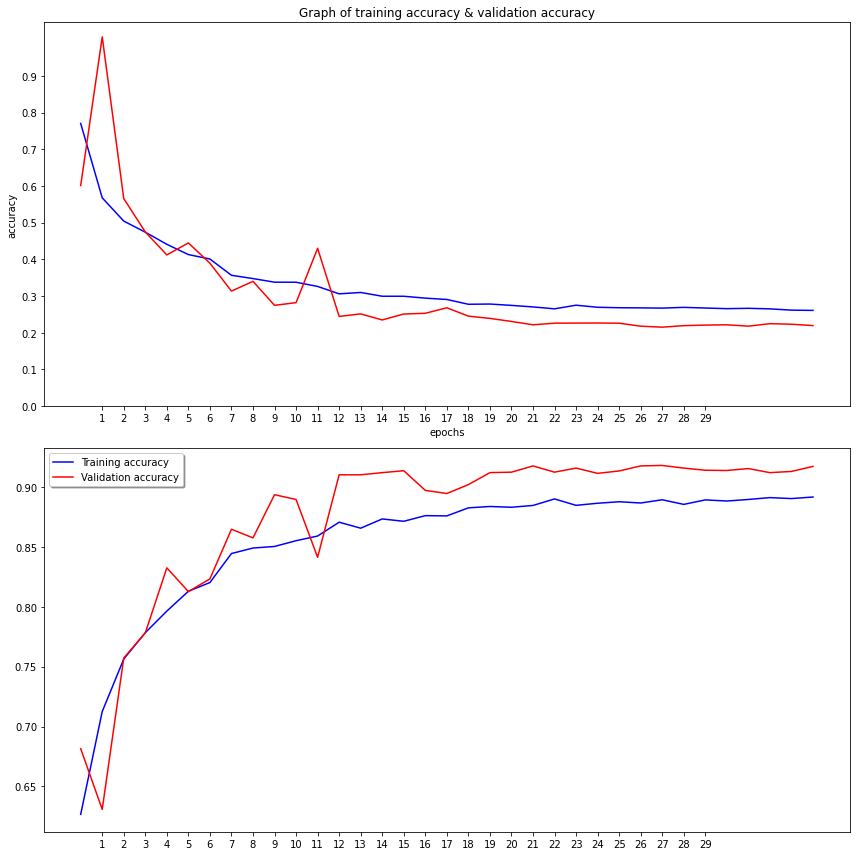

In [32]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# plot graph of training loss & validation loss
ax1.plot(classifier.history['loss'], color='b', label="Training loss")
ax1.plot(classifier.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, 30, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
ax1.set_xlabel("epochs")
ax1.set_ylabel("loss")
ax1.set_title("Graph of training loss & validation loss")

# plot graph of training accuracy & validation accuracy
ax2.plot(classifier.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(classifier.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, 30, 1))
ax1.set_xlabel("epochs")
ax1.set_ylabel("accuracy")
ax1.set_title("Graph of training accuracy & validation accuracy")

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

# **6. Prepare Testing Data**

In [33]:
# unzip the dataset
from zipfile import ZipFile
zf = ZipFile('/content/test1.zip')
zf.extractall('/content/sample_data') #save files in selected folder
zf.close()

In [34]:
# create a dataframe and store all image files
test_filenames = os.listdir("/content/sample_data/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

## **6.1. Create Testing Generator**

In [35]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/content/sample_data/test1/",
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


# **7. Find Prediction**

In [36]:
# find prediction using predict_generator
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [37]:
# here "category" column store the index of higher predicted value
test_df['category'] = np.argmax(predict, axis=-1)

In [38]:
# here predicted value will replace by "cat" for 0 & "dog" for 1
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [39]:
# See predicted dataframe
test_df.head()

,filename,category
0,8596.jpg,dog
1,5040.jpg,dog
2,6315.jpg,dog
3,4292.jpg,cat
4,7065.jpg,dog


## **7.1. Visualize Result**

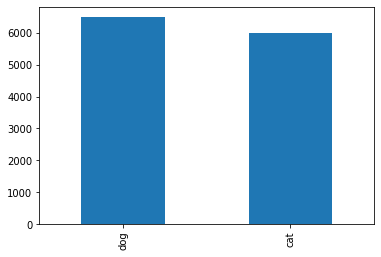

In [40]:
# see how many images classify into which class 
test_df['category'].value_counts().plot.bar()

## **7.2. See Predicted Image With Images**

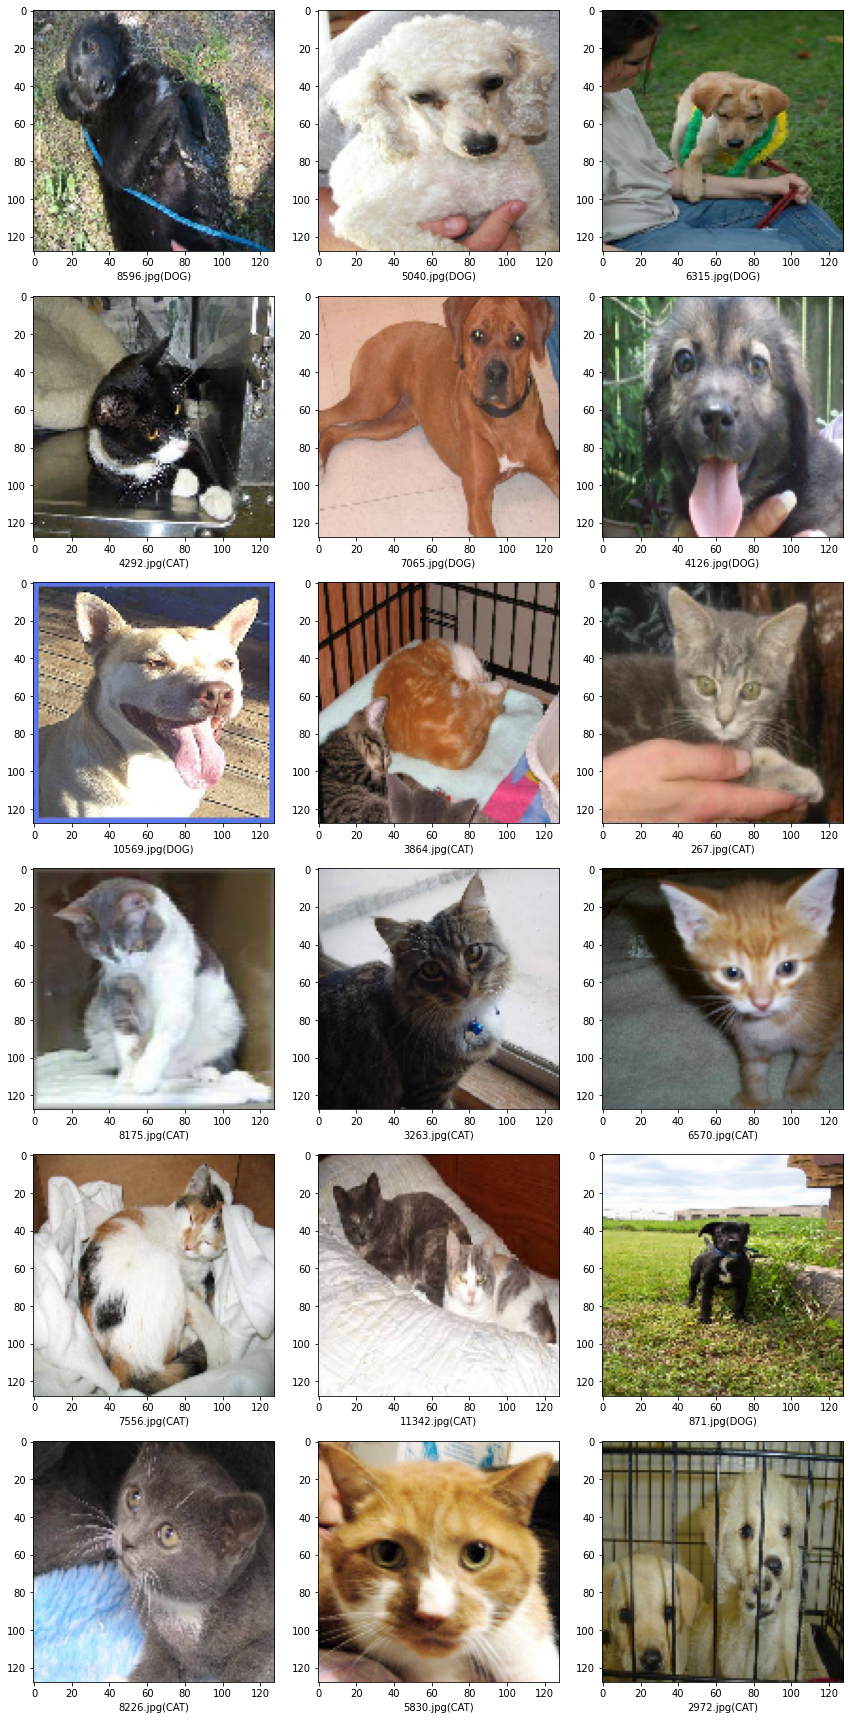

In [41]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/content/sample_data/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category.upper()) + ')' )
plt.tight_layout()
plt.show()

If you get any issues during run this notebook.Feel free to contact.
[Linkedin](https://www.linkedin.com/in/sidharth178),
[Github](https://github.com/sidharth178)

Thank You.
